In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras
#from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import cv2


In [ ]:
!mkdir = anime_face

In [ ]:
!unzip /content/drive/MyDrive/DL_Data/anime_face.zip -d anime_face

In [ ]:
import glob
from google.colab.patches import cv2_imshow
count = 1
real_image = []
for img in glob.glob('/content/anime_face/data/data/*.png'):
    real_image.append(cv2.imread(img))


In [ ]:
real_image[0].shape

(64, 64, 3)

In [ ]:
latent_dim = 100
height = 64
width = 64
channels = 3

# Discriminator

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, LeakyReLU, Dropout, Dense, Reshape, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.utils import plot_model


In [ ]:
from keras import backend
 
# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [ ]:

# clip model weights to a given hypercube
class ClipConstraint():
	# set clip value when initialized
	def __init__(self, clip_value):
		self.clip_value = clip_value
 
	# clip model weights to hypercube
	def __call__(self, weights):
		return backend.clip(weights, -self.clip_value, self.clip_value)
 
	# get the config
	def get_config(self):
		return {'clip_value': self.clip_value}



In [ ]:
def _critic():
  const = ClipConstraint(0.01)
  input = Input(shape=(64,64,3))
  x = Conv2D(filters = 64, kernel_size = (4,4), padding = 'same',strides=2, kernel_constraint = const)(input)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = 128, kernel_size = (4,4), strides = 2, padding = 'same', kernel_constraint = const)(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = 256, kernel_size = (4,4), strides = 2, padding = 'same', kernel_constraint = const)(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha = 0.2)(x)
  x = Conv2D(filters = 512, kernel_size = (4,4), strides = 2, padding = 'same', kernel_constraint = const)(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU()(x)
  x = Flatten()(x)
  x = Dropout(0.4)(x)
  x = Dense(1, activation = 'linear')(x)
  # model
  model = Model(inputs = [input], outputs = [x])
  # compile
  opt = RMSprop(lr=0.0005)
  model.compile(loss= wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  return model



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


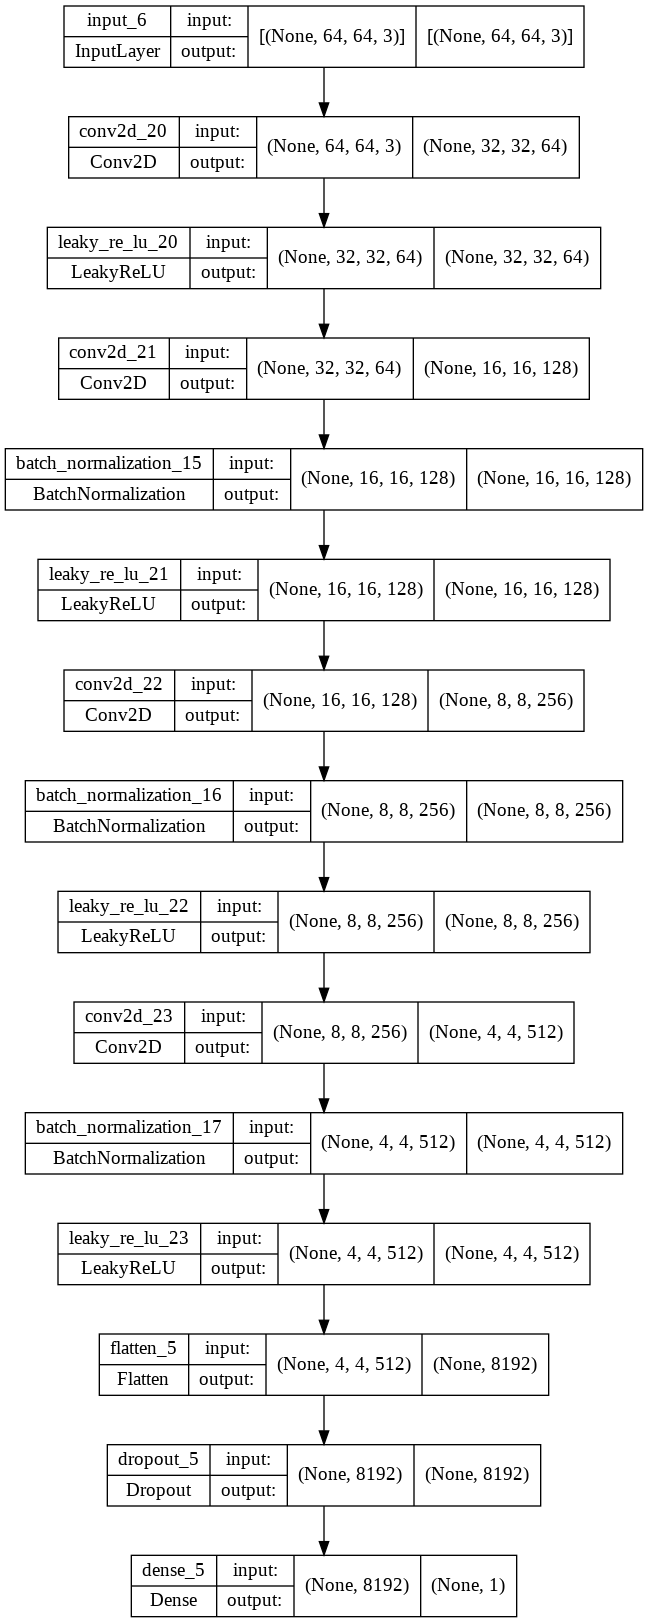

In [ ]:
critic = _critic()
plot_model(critic, show_shapes=True)


# Generator

Start from the output of discriminator 7x7 to become a 28x28 as the beginning

In [ ]:
from tensorflow.keras.layers import Conv2DTranspose


In [ ]:
def _generator(noise_size = 100):
  n_units = 4*4*512
  inpt = Input(shape=(noise_size))
  x = Dense(n_units)(inpt)
  x = LeakyReLU(alpha=0.2)(x)
  x = Reshape((4,4,512))(x)
  x = Conv2DTranspose(512, kernel_size=(4,4), strides=(2,2), padding='same')(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same')(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(128, kernel_size=(4,4), strides=(2,2), padding='same')(x)
  x = BatchNormalization(momentum=0.5)(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2DTranspose(64, kernel_size=(4,4), strides=(2,2), padding='same')(x)
  x = LeakyReLU(alpha=0.2)(x)
  x = Conv2D(filters=3, kernel_size=(64, 64), activation='tanh', padding='same')(x)

  model = Model(inputs = [inpt], outputs = [x])
  opt = RMSprop(lr=0.0005)
  model.compile(loss=wasserstein_loss, optimizer=opt, metrics=['accuracy'])
  return model





/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


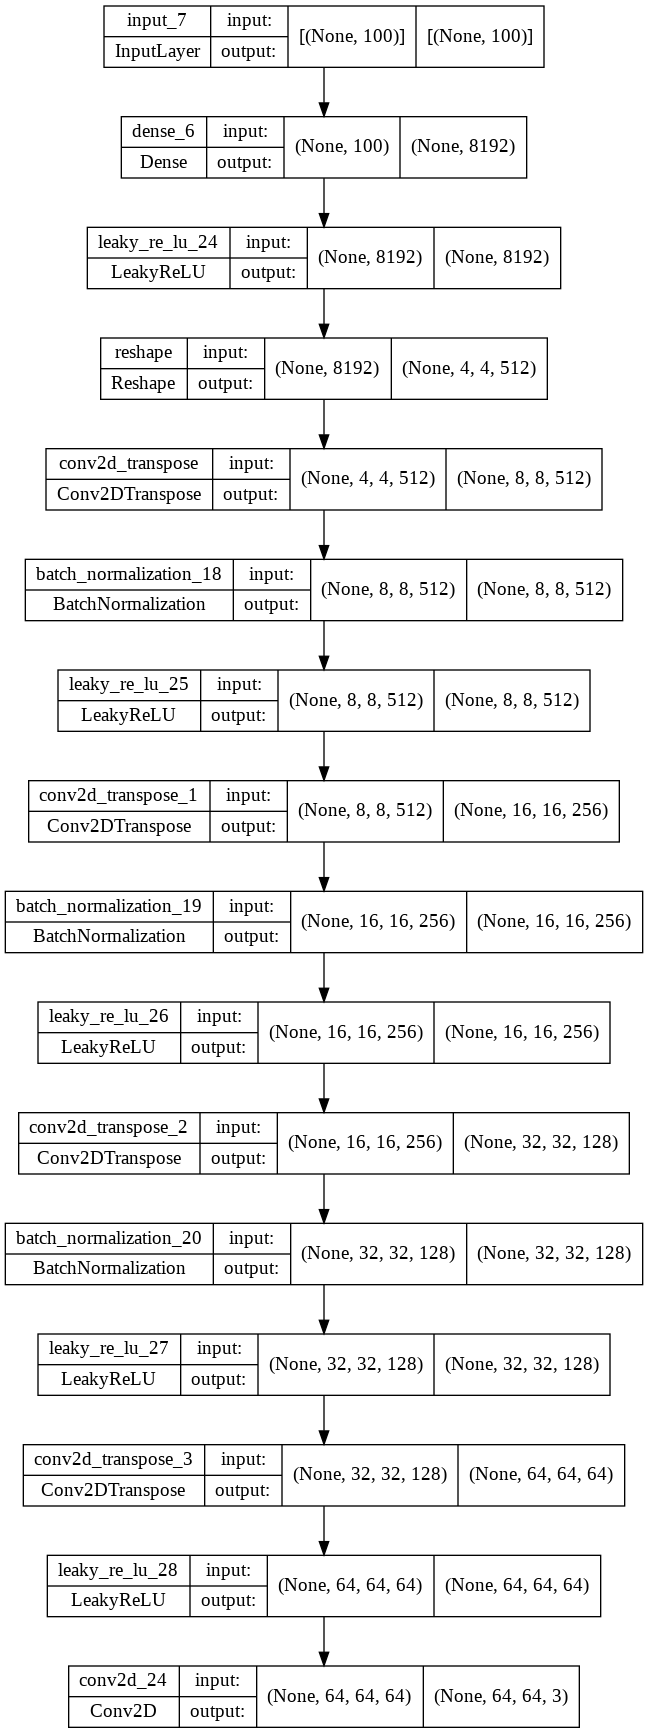

In [ ]:
generator = _generator()
plot_model(generator, show_shapes=True)

# GAN model

In [ ]:
from tensorflow.keras.models import Sequential


In [ ]:
def _gan(g_model, c_model):
  # freeze weights of discriminator
	c_model.trainable = False
	# Initiating model GAN
	model = Sequential()
	model.add(g_model)
	model.add(c_model)
	# compile model
	opt = RMSprop(lr=0.0005)
	model.compile(loss=wasserstein_loss, optimizer=opt)
	return model

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


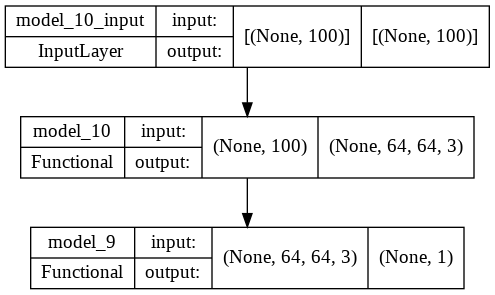

In [ ]:
# vector input of generator.
latent_dim = 100
# Initiating discriminator and generatator model
c_model = _critic()
g_model = _generator(latent_dim)
# Initiating GAN model
gan_model = _gan(g_model, c_model)
plot_model(gan_model, show_shapes=True)


# Data Processing

In [ ]:
real_image = np.asarray(real_image)
real_image.shape

(21551, 64, 64, 3)

In [ ]:
def _normalize(X):
	# If we use range from [-1;1] (X/127.5 - 1) -> activation = 'tanh'
	X = X.astype('float32')
	X = (X / 127.5) - 1
	return X

In [ ]:
# Generating input for generator
def generate_latent_points(latent_dim, n_samples):
	# Initializing randomly
	x_input = np.random.randn(latent_dim * n_samples)
	# reshape 
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# Fake sample, label = 0
def generate_fake_samples(g_model, latent_dim, n_samples):
	# Using noise vectors
	x_input = generate_latent_points(latent_dim, n_samples)
	# Generating
	X = g_model.predict(x_input)
	# Labelling = 1 for fake samples
	y = np.ones((n_samples, 1))
	return X, y

In [ ]:
def generate_real_samples(dataset, n_samples):
	# Picking randomly real samples id
	ix = np.random.randint(0, dataset.shape[0], n_samples)
	X = dataset[ix]
	# Labelling = -1 for real samples
	y = -np.ones((n_samples, 1))
	return X, y

# Training Model

In [ ]:
# Performace function
def summarize_performance(epoch, gan_model, X_real, y_real, X_fake, y_fake):
	_, acc_real = gan_model.layers[1].evaluate(X_real, y_real, verbose=0)
	_, acc_fake = gan_model.layers[1].evaluate(X_fake, y_fake, verbose=0)
	# discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))


In [ ]:
def train(g_model, c_model, gan_model, dataset, latent_dim, n_epochs=10000, batch_size=64):
  bat_per_epo = int(dataset.shape[0] / batch_size)
  half_batch = int(batch_size / 2)
  # Training model per each epoch
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      print('Epochs %d, batch %d' % (i+1,j+1))
      # Step 1: Training discriminator
      gan_model.layers[0].trainable = False
      gan_model.layers[1].trainable = True
      # Initializing Batch, in which 50% = real, 50% = fake
      X_real, y_real = generate_real_samples(dataset, half_batch)
      X_fake, y_fake = generate_fake_samples(gan_model.layers[0], latent_dim, half_batch)
      X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

      # Training process (discriminator or gan_model_layer[1])
      c_loss, _ = gan_model.layers[1].train_on_batch(X, y)
      
      
      # Step 2: Training generator
      # Initializing batch 
      X_gan = generate_latent_points(latent_dim, batch_size)
      # Labelling = -1 as real data for generated data from generator 
      y_gan = -np.ones((batch_size, 1))
      # Training process
      gan_model.layers[0].trainable = True
      gan_model.layers[1].trainable = False
      g_loss = gan_model.train_on_batch(X_gan, y_gan)

      # After 50 batchs, we print loss function from discriminator, generator, and the overall performace
      if (j+1) % 50 == 0:
        print('loss of discriminator: >%d, %d/%d, d=%.3f' % (i+1, j+1, bat_per_epo, c_loss))
        print('loss of generator: >%d, %d/%d, g=%.3f' % (i+1, j+1, bat_per_epo, g_loss))
        summarize_performance(j, gan_model, X_real, y_real, X_fake, y_fake)  



In [ ]:
dataset = _normalize(real_image)
dataset.shape

In [ ]:
train(g_model, c_model, gan_model, dataset, latent_dim = 100)

In [60]:
X_eval, y_eval = generate_fake_samples(g_model=gan_model.layers[0], latent_dim=100, n_samples=25)
X_eval = (X_eval + 1) * 127.5


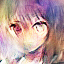

True

In [65]:

cv2_imshow(X_eval[10])
cv2.imwrite('demo_result.jpg',X_eval[0])


In [62]:
result = []
for i in X_eval:
  result.append(cv2.cvtColor(i,cv2.COLOR_BGR2RGB))


In [63]:
def _plot(X):
	for i in range(25):
		# define subplot
		plt.subplot(5, 5, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(result[i].astype(np.uint8))
	plt.show()

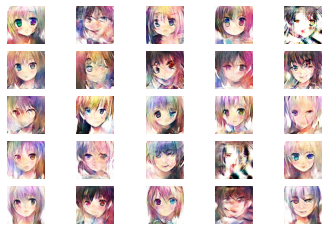

In [64]:
_plot(X_eval)